In [1]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on October 14 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu
"""

'\nCreated on October 14 2018\n@author: Neven Caplar\n@contact: ncaplar@princeton.edu\n'

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [32]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 16})
%config InlineBackend.rc = {}
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances

DATA_DIRECTORY='/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/'

In [179]:
np.__version__

'1.15.4'

# Preparation of sql query

In [11]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html

dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

In [10]:
#extract ra and dec values for SQL query

data = np.zeros(len(Positions_of_dr7), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = Positions_of_dr7[:,0]
data['dec'] =  Positions_of_dr7[:,1]

PositionOfQuasars=data

np.save(DATA_DIRECTORY+'PositionOfQuasars',PositionOfQuasars)

In [11]:
PositionOfQuasar=np.load(DATA_DIRECTORY+'PositionOfQuasars.npy')

In [89]:
#############################
# This is how to find create values to be feed to SQL query system for HSC
# This query creates the table that we import in the analysis part below (so it can be skipped if you just want to just analyze result of this query).
# In terminal run command seen below - this is code which I modified from https://hsc-gitlab.mtk.nao.ac.jp/snippets/13
# Run the command in Python 2!!!
# the part in the command below that says <--columns ["g_cmodel_mag","g_cmodel_mag"]> does not mean I am just taking g_cmodel magnitude - I needed something as a filler

# run 'python CatalogCreator.py PositionOfQuasars.npy --columns ["g_cmodel_mag","g_cmodel_mag"]'

#############################

In [ ]:
# This is example of the SQL query to find the data
# Copy paste result from the CatalogCreator.py (also avaliable on github) command into VALUES() bracket, make sure VALUES() is in only one line, and run query at https://hscdata.mtk.nao.ac.jp:4443/datasearch/
# This run took around 3 hours

'''
WITH
    user_catalog("user.ra","user.dec") AS (VALUES('2.7227999642500000e-02'::double precision,'5.1534098386799998e-01'::double precision),('3.3900000154999999e-02','2.7630099654200002e-01'),('3.8603998720599997e-02','1.5298477172900000e+01'),('3.9089001715200002e-02','1.3938449859600000e+01'),('3.9271000772700002e-02','-1.0464426040599999e+01'),('4.7548998147199997e-02','1.4929354667700000e+01'),('4.9839001148899997e-02','4.0364999324100002e-02'),('5.1079001277700001e-02','-5.3904700279200002e-01'),('5.4786998778600000e-02','1.4176302909900000e+01'),('5.7505998760499999e-02','-9.1300100088100000e-01'))
    ,
    match AS (
        SELECT
            object_id,
            earth_distance(coord, ll_to_earth("user.dec", "user.ra")) AS match_distance,
            user_catalog.*
        FROM
            user_catalog JOIN s18a_wide.forced
                ON coneSearch(coord, "user.ra", "user.dec", 0.1) 
    )
SELECT
	f.ra,
	f.dec,
	f.g_cmodel_mag,
	f.g_cmodel_magsigma,
	f.r_cmodel_mag,
	f.r_cmodel_magsigma,
	f.i_cmodel_mag,
	f.i_cmodel_magsigma,
    f2.g_psfflux_mag,
    f2.g_psfflux_magsigma,
    f2.r_psfflux_mag,
    f2.r_psfflux_magsigma,
    f2.i_psfflux_mag,
    f2.i_psfflux_magsigma,
    f.object_id
FROM
    match LEFT JOIN s18a_wide.forced AS f USING(object_id)
JOIN s18a_wide.forced2 AS f2 ON f.object_id = f2.object_id
WHERE
    f.isprimary
'''

In [ ]:
# This is the example of the SQL query to find the data, as ran on the server on February 8, 2019
# Added quality flags from Yusra AlSayyad
# Copy paste result from the CatalogCreator.py (also avaliable on github) command into VALUES() bracket, make sure VALUES() is in only one line, and run query at https://hscdata.mtk.nao.ac.jp:4443/datasearch/
# This run took around 3 hours

'''
WITH
    user_catalog("user.ra","user.dec") AS (VALUES('2.7227999642500000e-02'::double precision,'5.1534098386799998e-01'::double precision),('3.3900000154999999e-02','2.7630099654200002e-01'),('3.8603998720599997e-02','1.5298477172900000e+01'),('3.9089001715200002e-02','1.3938449859600000e+01'),('3.9271000772700002e-02','-1.0464426040599999e+01'),('4.7548998147199997e-02','1.4929354667700000e+01'),('4.9839001148899997e-02','4.0364999324100002e-02'),('5.1079001277700001e-02','-5.3904700279200002e-01'),('5.4786998778600000e-02','1.4176302909900000e+01'),('5.7505998760499999e-02','-9.1300100088100000e-01'))
    ,
    match AS (
        SELECT
            object_id,
            earth_distance(coord, ll_to_earth("user.dec", "user.ra")) AS match_distance,
            user_catalog.*
        FROM
            user_catalog JOIN s18a_wide.forced
                ON coneSearch(coord, "user.ra", "user.dec", 0.1) 
    )
SELECT
	f.ra,
	f.dec,
	f.g_cmodel_mag,
	f.g_cmodel_magsigma,
	f.r_cmodel_mag,
	f.r_cmodel_magsigma,
	f.i_cmodel_mag,
	f.i_cmodel_magsigma,
    f2.g_psfflux_mag,
    f2.g_psfflux_magsigma,
    f2.r_psfflux_mag,
    f2.r_psfflux_magsigma,
    f2.i_psfflux_mag,
    f2.i_psfflux_magsigma,
    f.object_id
FROM
    match LEFT JOIN s18a_wide.forced AS f USING(object_id)
JOIN s18a_wide.forced2 AS f2 ON f.object_id = f2.object_id
WHERE
    f.isprimary
    AND NOT f.g_psfflux_flag
    AND NOT f.r_psfflux_flag
    AND NOT f.i_psfflux_flag
    AND NOT f.g_cmodel_flag 
    AND NOT f.r_cmodel_flag
    AND NOT f.i_cmodel_flag
    AND NOT f.g_pixelflags_edg
    AND NOT f.r_pixelflags_edge
    AND NOT f.i_pixelflags_edge        
    AND NOT f.g_pixelflags_bad 
    AND NOT f.r_pixelflags_bad
    AND NOT f.i_pixelflags_bad
    AND NOT f.g_pixelflags_interpolatedcenter
    AND NOT f.r_pixelflags_interpolatedcenter
    AND NOT f.i_pixelflags_interpolatedcenter
    AND NOT f.g_pixelflags_saturatedcenter 
    AND NOT f.r_pixelflags_saturatedcenter
    AND NOT f.i_pixelflags_saturatedcenter
    AND NOT f.g_pixelflags_crcenter
    AND NOT f.r_pixelflags_crcenter
    AND NOT f.i_pixelflags_crcenter
'''

# Analysis of the output

## Initial Analysis

In [9]:
#read in catalogue from HSC query with pandas
#This is the version without quality flags
#df = pd.read_csv(DATA_DIRECTORY+'192565.csv')

#version with flags
df = pd.read_csv(DATA_DIRECTORY+'194782.csv')

# give ra and dec
Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])

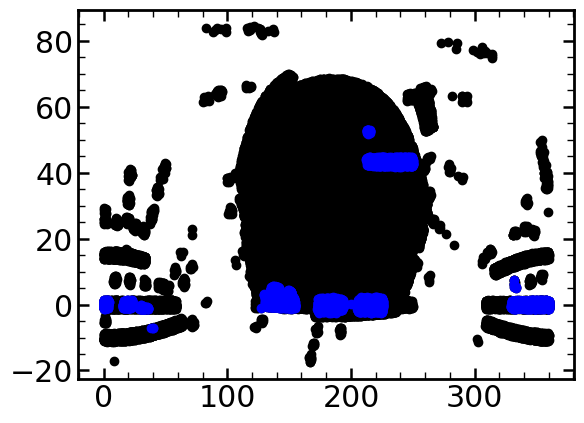

In [12]:
# check the overlap with SDSS
# import dr7 (at the start of section 1), if you skipped section 1

plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue')

In [13]:
# takes a bit less than 1 minute on my laptop
# this matches QSO from SDSS and resulting catalog from HSC
res=[]
for j in tqdm(range(len(Positions_of_dr7))):
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res.append([shortest_distance,df.loc[shortest_distance_index].values])

100%|████████████████████████████████████████████████████████████████████| 105645/105645 [00:42<00:00, 2507.95it/s]


In [14]:
# extract columns 1,2,8,9,10,11,12,13 from SDSS, which are just ra, dec, and measurments in different bands
matched_array=[]
for i in tqdm(range(len(res))):
    if res[i][0]>0.001:
        pass
    else:
        matched_array.append(np.concatenate((dr7.loc[i][[1,2,8,9,10,11,12,13]],res[i][1])))
        
matched_array=np.array(matched_array)

100%|███████████████████████████████████████████████████████████████████| 105645/105645 [00:06<00:00, 16906.50it/s]


In [15]:
# filter out QSO which failed measurment, (g-band set at 0 in SDSS catlog)
matched_array_filtered=matched_array[matched_array[:,2]>16]

(17, 25)

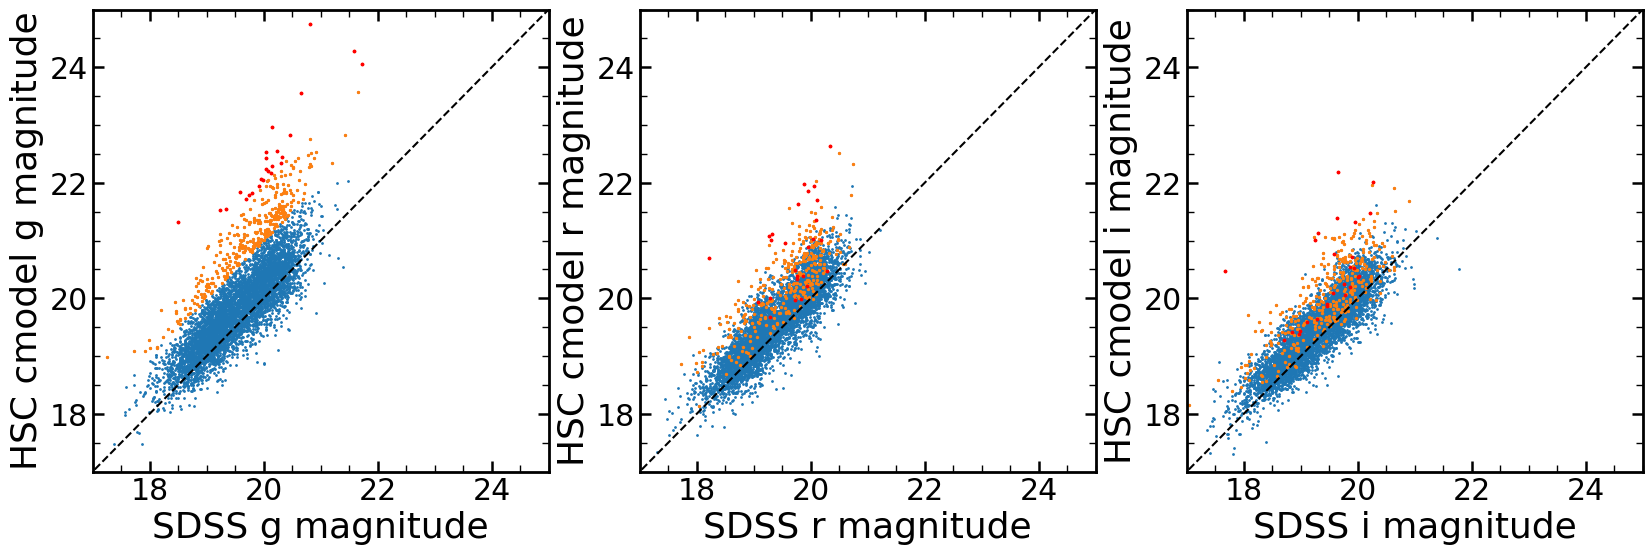

In [18]:
# plot differences using cmodel values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,2],matched_array_filtered[:,8+2],s=1)
plt.scatter(matched_array_filtered[:,2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,8+2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,8+2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC cmodel g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,8+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC cmodel r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,8+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC cmodel i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

(17, 25)

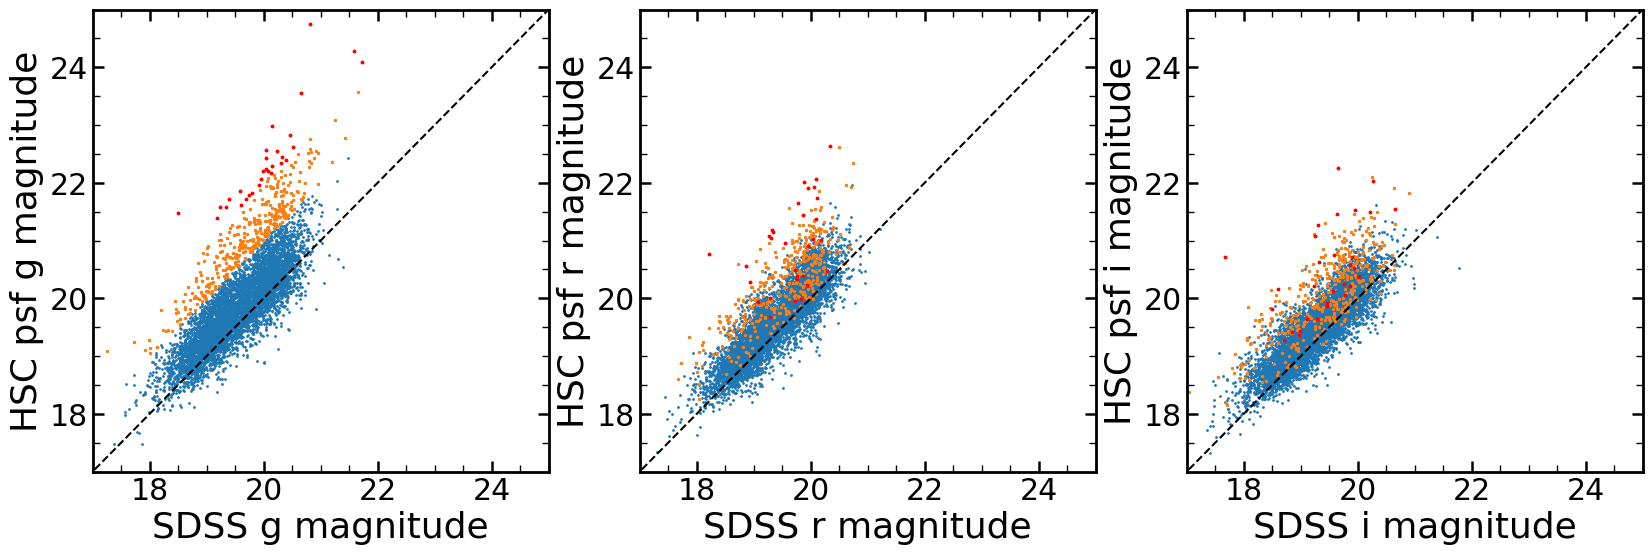

In [19]:
# plot differences using psf values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,2],matched_array_filtered[:,14+2],s=1)
plt.scatter(matched_array_filtered[:,2][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,14+2][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,2][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,14+2][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)
plt.subplot(133)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+2]-matched_array_filtered[:,2])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

## Adding MacLeod catalogue

In [20]:
#########
#Can be skipped, just used for consistency check and to compare results
#########

#read in catalogue with pandas
MacLeod_Cat= np.loadtxt(DATA_DIRECTORY+'MacLeod2019_tab2.txt',dtype='str')

ra_dec_MacLeod_Cat_step1=[]
for i in range(len(MacLeod_Cat)):
    if '+' in MacLeod_Cat[:,0][i]:
        split_string=str.split(MacLeod_Cat[:,0][i],'+')
        split_string.insert(1,'+1')
        ra_dec_MacLeod_Cat_step1.append(split_string)
    else:
        split_string=str.split(MacLeod_Cat[:,0][i],'-')
        split_string.insert(1,'-1')
        ra_dec_MacLeod_Cat_step1.append(split_string)

ra_dec_MacLeod_Cat_step1=np.array(ra_dec_MacLeod_Cat_step1)

In [21]:
# split strings from MacLeod catalogue 
ra_dec_MacLeod_Cat_step2=[]
n=2
for i in range(len(ra_dec_MacLeod_Cat_step1)):
    ra_string=ra_dec_MacLeod_Cat_step1[i][0]
    dec_string=ra_dec_MacLeod_Cat_step1[i][2]
    ra_string_split=[ra_string[i:i+n] for i in range(0, len(ra_string), n)]
    dec_string_split=[dec_string[i:i+n] for i in range(0, len(dec_string), n)]
    ra_split=[float(ra_string_split[0]),float(ra_string_split[1]),float(ra_string_split[2]),float(ra_string_split[3]),float(ra_string_split[4])]
    dec_split=[float(ra_dec_MacLeod_Cat_step1[0][1])*float(dec_string_split[0]),float(dec_string_split[1]),float(dec_string_split[2]),float(dec_string_split[3])]
    ra_dec_MacLeod_Cat_step2.append([ra_split,dec_split])

In [22]:
# move in the same format as other catalogues
ra_dec_MacLeod_Cat_step3=[]
for i in range(len(ra_dec_MacLeod_Cat_step2)):
    ra_dec_MacLeod_Cat_step3.append([ra_dec_MacLeod_Cat_step2[i][0][0]*15+(ra_dec_MacLeod_Cat_step2[i][0][1]/60)*15+((ra_dec_MacLeod_Cat_step2[i][0][2]+ra_dec_MacLeod_Cat_step2[i][0][3])/3600)*15,
     ra_dec_MacLeod_Cat_step2[i][1][0]+(ra_dec_MacLeod_Cat_step2[i][1][1]/60)+(ra_dec_MacLeod_Cat_step2[i][1][2]/3600)])
    
ra_dec_MacLeod_Cat_step3=np.array(ra_dec_MacLeod_Cat_step3)

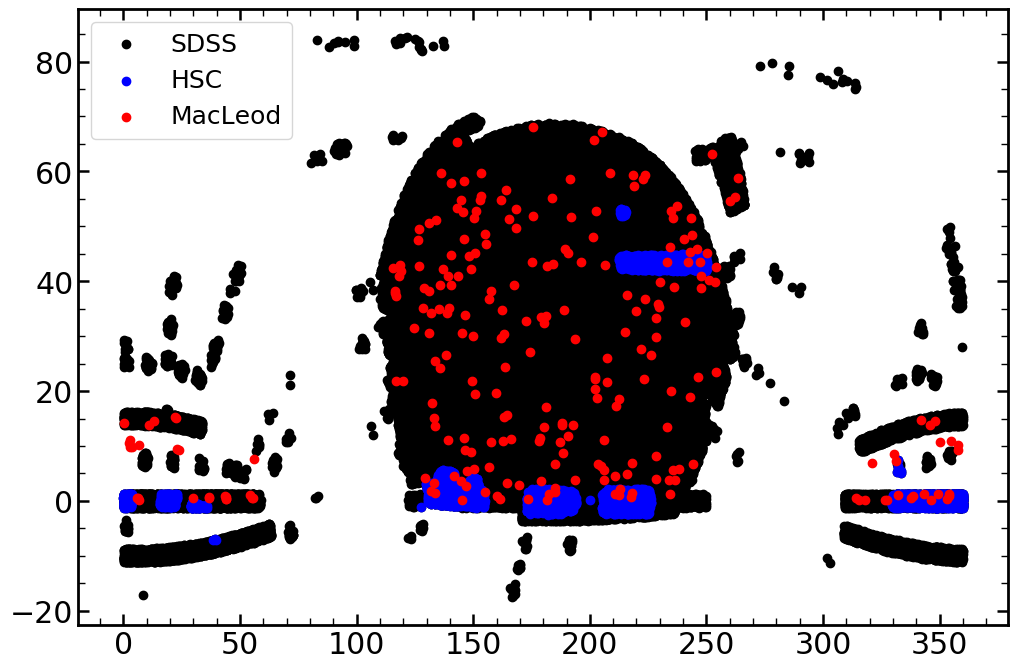

In [23]:
# check the overlap with SDSS
plt.figure(figsize=(12,8))
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black',label='SDSS')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue',label='HSC')
plt.scatter(ra_dec_MacLeod_Cat_step3[:,0],ra_dec_MacLeod_Cat_step3[:,1],color='red',label='MacLeod')
plt.legend()

In [24]:
# again takes around a minute
res=[]
for j in tqdm(range(len(Positions_of_dr7))):
    
    #HSC catalogue search; same as above
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance_HSC=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_HSC=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_HSC)[0][0]
    
    
    
    #MacLeod catalogue search; same as above
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],ra_dec_MacLeod_Cat_step3)
    # shortest distance
    shortest_distance_MacLeod=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_MacLeod=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_MacLeod)[0][0]    
    
    res.append([shortest_distance_HSC,shortest_distance_MacLeod,df.loc[shortest_distance_index_HSC].values,MacLeod_Cat[shortest_distance_index_MacLeod]])

100%|████████████████████████████████████████████████████████████████████| 105645/105645 [00:53<00:00, 1976.42it/s]


In [25]:
# extract columns 1,2,8,9,10,11,12,13 from SDSS, which are: sdss id, ra, dec, and measurments in different bands (gri)
matched_array_MacLeod_SDSS=[]
not_matched_array_MacLeod_SDSS=[]
for i in tqdm(range(len(res))):
    # is object close to HSC 
    if res[i][0]>0.001:
        pass
    else:
        # if the objects is avaliabe in HSC, searc for it in MacLeod
        if res[i][1]>0.001:
            pass
        else:
            # join the SDSSvalue, with the value from HSC and MacLeod
            matched_array_MacLeod_SDSS.append(np.concatenate((dr7.loc[i][[0,1,2,8,9,10,11,12,13]],res[i][2],res[i][3])))
        
matched_array_MacLeod_SDSS=np.array(matched_array_MacLeod_SDSS)

100%|█████████████████████████████████████████████████████████████████| 105645/105645 [00:00<00:00, 1324249.86it/s]


number of objects that have been found is: 11


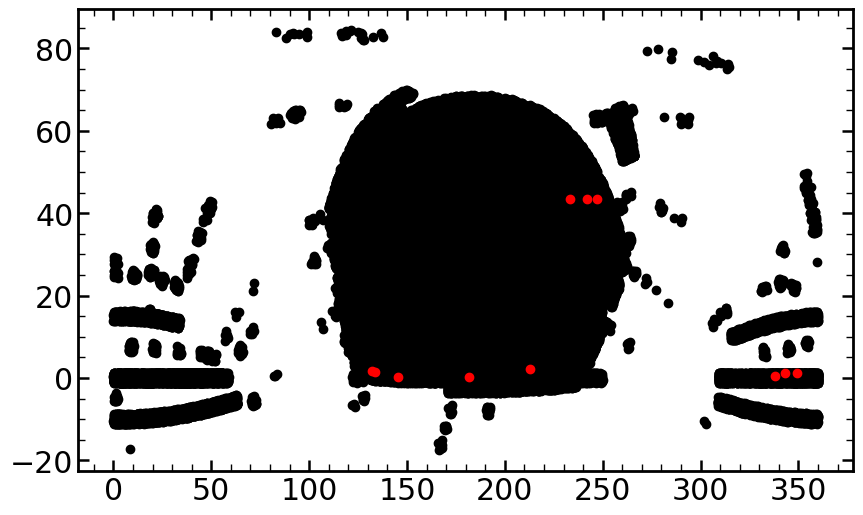

In [26]:
# check the overlap of the matched_array_MacLeod_SDSS wit the SDSS
print('number of objects that have been found is: '+str(len(matched_array_MacLeod_SDSS)))
plt.figure(figsize=(10,6))
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(matched_array_MacLeod_SDSS[:,1],matched_array_MacLeod_SDSS[:,2],color='red')


In [274]:
# columns of matched_array_MacLeod_SDSS
# 0. SDSS ID, 1. ra (SDSS), 2. dec (SDSS), 3. g-mag (SDSS) 4. sigma g-mag (SDSS), 5. r-mag (SDSS) 6. sigma r-mag (SDSS), 7. i-mag (SDSS) 8. sigma i-mag (SDSS)
# 9. ra (HSC), 10. dec (HSC), 11. g_cmodel_mag, 12. g_cmodel_magsigma, 13. r_cmodel_mag, 14. r_cmodel_magsigma, 15. i_cmodel_mag, 16. i_cmodel_magsigma,
# 17. g_psfflux_mag, 18. g_psfflux_magsigma, 19. r_psfflux_mag, 20. r_psfflux_magsigma, 21. i_psfflux_mag, 22. i_psfflux_magsigma, 23. object_id
# 24. SDSSJID, 25. z, 26. morph. flag (=0 for point source, 1 for extended), 27. Phot. MJD_1, 28. g_1 (mag), 29. sigma_1 (mag), 30. Phot. MJD_2
# 31. g_2 (mag), 32. sigma_2 (mag), 33. Spec. MJD_1, 34.  MJD (PS1), 35. g_PS1 (mag), 36. sigma_PS1 (mag), 37. Spec. MJD_2, 38. Facility , 
# 39. CLQ by VI?  (=1 for visual CLQ, 0 otherwise), 40. N_sigma (Hbeta) 

In [27]:
# Check that you selected correct objects by comparing SDSS and MacLeod catalogue
is_correctly_matched=[]
for i in range(len(matched_array_MacLeod_SDSS)):
    is_correctly_matched.append(matched_array_MacLeod_SDSS[i][0]==matched_array_MacLeod_SDSS[i][24])
    
# if result is 1, it is correct
print(np.mean(is_correctly_matched))

1.0


(17, 23)

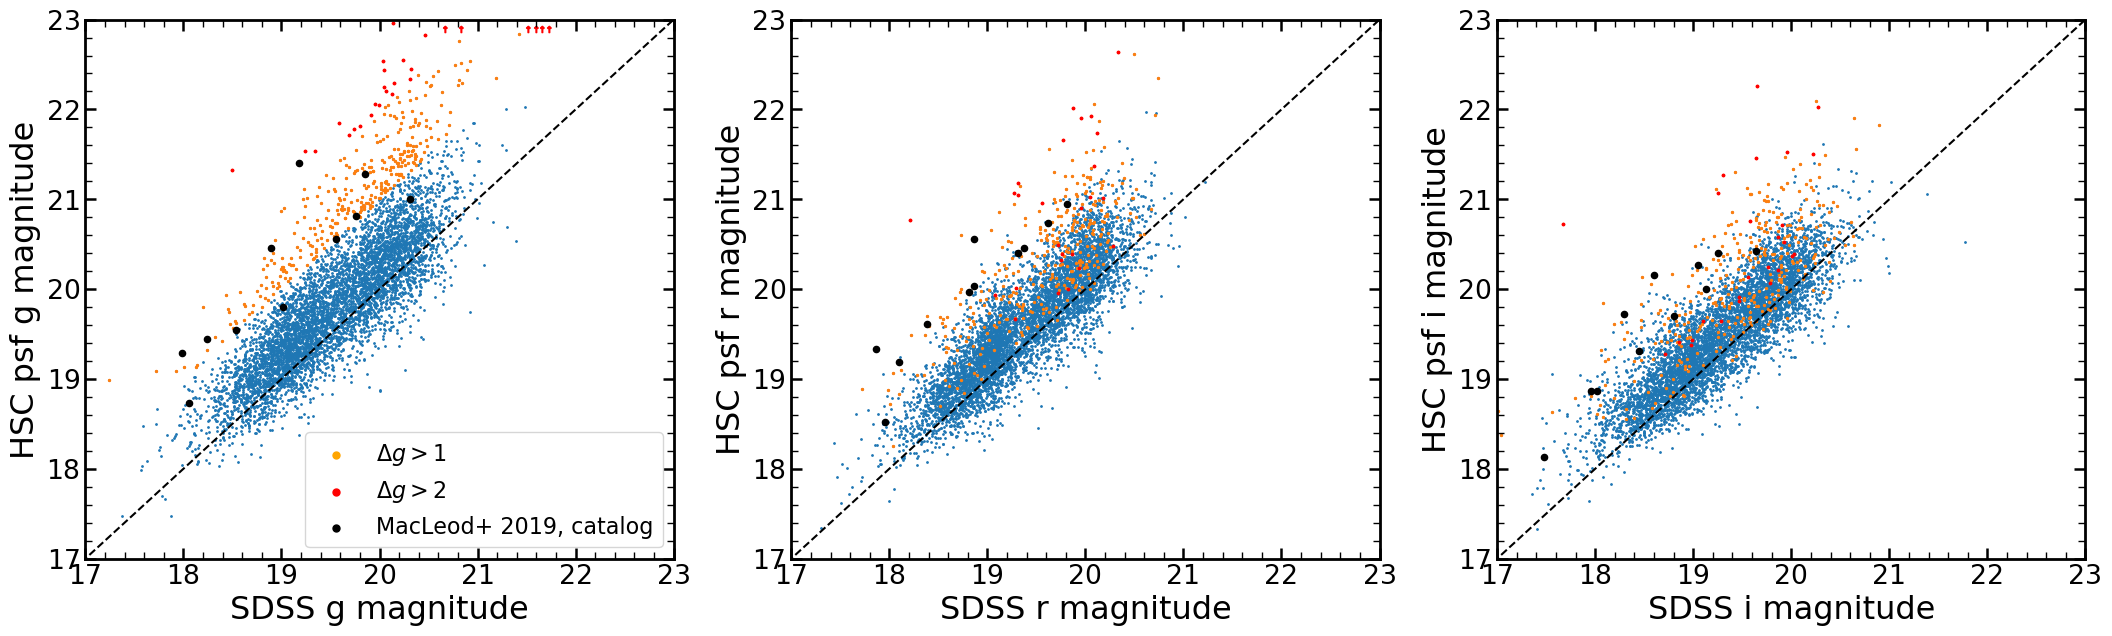

In [71]:
selection_of_objects_1_mag_dimmer=(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1
selection_of_objects_2_mag_dimmer=(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2
arrowup = u'$\u2191$'

plt.figure(figsize=(20,7))
plt.subplot(131)

plt.subplots_adjust(left=-0.10)

plt.scatter(matched_array_filtered[:,2],matched_array_filtered[:,8+2],s=1)
plt.scatter(matched_array_filtered[:,2][selection_of_objects_1_mag_dimmer],
            matched_array_filtered[:,8+2][selection_of_objects_1_mag_dimmer],s=2)
plt.scatter(matched_array_filtered[:,2][selection_of_objects_2_mag_dimmer],
            matched_array_filtered[:,8+2][selection_of_objects_2_mag_dimmer],s=3,color='red')
plt.scatter(match_array_faint,
            np.full(len(match_array_faint),22.9),s=20,color='red',marker=arrowup)
plt.scatter(matched_array_MacLeod_SDSS[:,3],matched_array_MacLeod_SDSS[:,17],s=20,color='black')

plt.scatter([], [], c='orange', s=25,label='$\Delta g>1$')
plt.scatter([], [], c='red',  s=25,label='$\Delta g>2$')
plt.scatter([], [], c='black', s=25,label='MacLeod+ 2019, catalog')
plt.legend(loc=4)

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][selection_of_objects_1_mag_dimmer],matched_array_filtered[:,14+4][selection_of_objects_1_mag_dimmer],s=2)
plt.scatter(matched_array_filtered[:,4][selection_of_objects_2_mag_dimmer],matched_array_filtered[:,14+4][selection_of_objects_2_mag_dimmer],s=3,color='red')
plt.scatter(matched_array_MacLeod_SDSS[:,5],matched_array_MacLeod_SDSS[:,19],s=20,color='black')

plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][selection_of_objects_1_mag_dimmer],matched_array_filtered[:,14+6][selection_of_objects_1_mag_dimmer],s=2)
plt.scatter(matched_array_filtered[:,6][selection_of_objects_2_mag_dimmer],matched_array_filtered[:,14+6][selection_of_objects_2_mag_dimmer],s=3,color='red')
plt.scatter(matched_array_MacLeod_SDSS[:,7],matched_array_MacLeod_SDSS[:,21],s=20,color='black')

plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

# Combining both c-model and psf magnitudes

In [81]:
# sdss g band mag - HSC g band mag
g_mag_dif=(matched_array_filtered[:,2]-matched_array_filtered[:,14+2]).astype(float)
# error sdss g band mag - HSC g band mag
g_mag_dif_err=np.sqrt(((matched_array_filtered[:,3]).astype(float))**2+((matched_array_filtered[:,14+3]).astype(float))**2)

In [82]:
# insert differences in the catalog
matched_array_filtered_with_g_mag_dif=np.insert(matched_array_filtered, 2, g_mag_dif, axis=1)
matched_array_filtered_with_g_mag_dif_and_err=np.insert(matched_array_filtered_with_g_mag_dif, 3, g_mag_dif_err, axis=1)

In [171]:
# extra step to get nice looking output when exported to .txt
data = np.zeros((len(matched_array_filtered_with_g_mag_dif_and_err)), dtype={'names':['ra (SDSS)', 'dec (SDSS)', 'Delta g-band','Delta g-band err', 'g-band (SDSS)', 'g-band err (SDSS)',
                                                                                   'r-band (SDSS)','r-band err (SDSS)','i-band (SDSS)','i-band err (SDSS)','ra (HSC)', 'dec (HSC)',
                                                                                   'g_cmodel_mag (HSC)','g_cmodel_magsigma (HSC)','r_cmodel_mag (HSC)','r_cmodel_magsigma (HSC)',
                                                                                   'i_cmodel_mag (HSC)','i_cmodel_magsigma (HSC)','g_psfflux_mag (HSC)','g_psfflux_magsigma (HSC)',
                                                                                  'r_psfflux_mag (HSC)','r_psfflux_magsigma (HSC)','i_psfflux_mag (HSC)', 'i_psfflux_magsigma (HSC)',
                                                                                   'object_id (HSC)'],
                          'formats':['f2', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','i8']})

In [172]:
for i in range(25):
    data[data.dtype.names[i]]=matched_array_filtered_with_g_mag_dif_and_err[:,i]

In [90]:
'''
matched_array_filtered_with_g_mag_dif_and_err_structured=np.array(np.transpose(matched_array_filtered_with_g_mag_dif_and_err),dtype=[('ra (SDSS)', 'f4'), ('dec (SDSS)', 'f4'),('Delta g-band', 'f4'),('Delta g-band err', 'f4'),('g-band (SDSS)', 'f4'),('g-band err (SDSS)', 'f4'),
                                                                                                                         ('r-band (SDSS)', 'f4'), ('r-band err (SDSS)', 'f4'),('i-band (SDSS)', 'f4'),('i-band err (SDSS)', 'f4'),
                                                                                                                         ('ra (HSC)', 'f4'), ('dec (HSC)', 'f4'),('g_cmodel_mag (HSC)', 'f4'), ('g_cmodel_magsigma (HSC)', 'f4'),
                                                                                                                         ('r_cmodel_mag (HSC)', 'f4'), ('r_cmodel_magsigma (HSC)', 'f4'),('i_cmodel_mag (HSC)', 'f4'), ('i_cmodel_magsigma (HSC)', 'f4'),
                                                                                                                          ('g_psfflux_mag (HSC)', 'f4'), ('g_psfflux_magsigma (HSC)', 'f4'),
                                                                                                                         ('r_psfflux_mag (HSC)', 'f4'), ('r_psfflux_magsigma (HSC)', 'f4'),('i_psfflux_mag (HSC)', 'f4'), ('i_psfflux_magsigma (HSC)', 'f4')
                                                                                                                         ,('object_id (HSC)', 'f4')])
'''

In [183]:
np.transpose(matched_array_filtered_with_g_mag_dif_and_err)

array([[0.027228, 0.0339, 0.051079, ..., 359.994452, 359.994688,
        359.997675],
       [0.5153409999999999, 0.276301, -0.539047, ..., -1.207033,
        0.562592, 0.14487],
       [0.041746700000000914, -0.09126850000000175, -0.20099419999999668,
        ..., -0.32136010000000326, -0.11139340000000075,
        -0.4957836000000029],
       ...,
       [20.072391500000002, 19.268171300000002, 20.1181564, ...,
        18.683204699999997, 19.4369888, 20.4915848],
       [0.0011004518, 0.000624895969, 0.0012234953500000001, ...,
        0.000827890704, 0.000618283171, 0.0013043866499999998],
       [4.164566505438386e+16, 4.164565646445851e+16,
        4.057694834212344e+16, ..., 4.05769354572133e+16,
        4.16456650543864e+16, 4.164565646445055e+16]], dtype=object)

In [177]:
np.array([data[0]])

array([(0.02722, 0.515341, 0.0417467, 0.03802512, 20.324, 0.038, 20.093, 0.041, 20.042, 0.121, 0.02721789, 0.5153451, 20.280323, 0.00146709, 20.273754, 0.00134791, 20.07159, 0.00110844, 20.282253, 0.00138191, 20.271421, 0.00132368, 20.072392, 0.00110045, 41645665054383856)],
      dtype=[('ra (SDSS)', '<f2'), ('dec (SDSS)', '<f4'), ('Delta g-band', '<f4'), ('Delta g-band err', '<f4'), ('g-band (SDSS)', '<f4'), ('g-band err (SDSS)', '<f4'), ('r-band (SDSS)', '<f4'), ('r-band err (SDSS)', '<f4'), ('i-band (SDSS)', '<f4'), ('i-band err (SDSS)', '<f4'), ('ra (HSC)', '<f4'), ('dec (HSC)', '<f4'), ('g_cmodel_mag (HSC)', '<f4'), ('g_cmodel_magsigma (HSC)', '<f4'), ('r_cmodel_mag (HSC)', '<f4'), ('r_cmodel_magsigma (HSC)', '<f4'), ('i_cmodel_mag (HSC)', '<f4'), ('i_cmodel_magsigma (HSC)', '<f4'), ('g_psfflux_mag (HSC)', '<f4'), ('g_psfflux_magsigma (HSC)', '<f4'), ('r_psfflux_mag (HSC)', '<f4'), ('r_psfflux_magsigma (HSC)', '<f4'), ('i_psfflux_mag (HSC)', '<f4'), ('i_psfflux_magsigma (HSC)', '

In [185]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_Feb_10.csv", matched_array_filtered_with_g_mag_dif_and_err, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#created on Feb 10, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#ra (SDSS) \n#dec (SDSS) \n#Delta g-band (g-band SDSS minus g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(Delta g-band err**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')

# (deprecated old code!!!) Analysis (deprecated old code!!!)

In [10]:
#read in catalogue with pandas
df = pd.read_csv(DATA_DIRECTORY+'179761.csv')

Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])

In [12]:
len(Positions_of_df)

31920

In [106]:
# takes a bit less than 4 minutes on my laptop
# this matches QSO from SDSS and resulting catalog from HSC
res=[]
for j in tqdm(range(len(Positions_of_dr7))):
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    for i in range(len(PositionOfQuasars_euclidean_distances)):
        res.append([np.min(PositionOfQuasars_euclidean_distances[i]),df.loc[list(PositionOfQuasars_euclidean_distances[i]).index(np.min(PositionOfQuasars_euclidean_distances[i]))].values])


  3%|▎         | 3650/105645 [00:07<03:41, 459.79it/s]Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 105645/105645 [03:38<00:00, 484.44it/s]


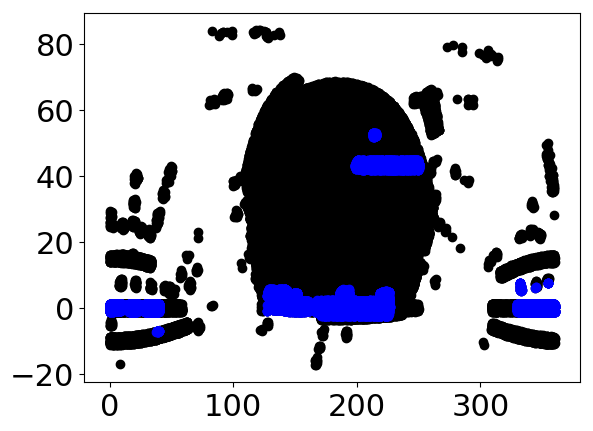

In [214]:
# check the overlap with SDSS
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue')

In [121]:
# extract columns 1,2,8,9,10,11,12,13 from SDSS, which are just ra, dec, and measurments in different bands
matched_array=[]
for i in tqdm(range(len(res))):
    if res[i][0]>0.001:
        pass
    else:
        matched_array.append(np.concatenate((dr7.loc[i][[1,2,8,9,10,11,12,13]],res[i][1])))
        
matched_array=np.array(matched_array)

100%|██████████| 105645/105645 [00:08<00:00, 12583.70it/s]


In [156]:
# filter out QSO which failed measurment, (g-band set at 0 in SDSS catlog)
matched_array_filtered=matched_array[matched_array[:,2]>16]

(16, 24)

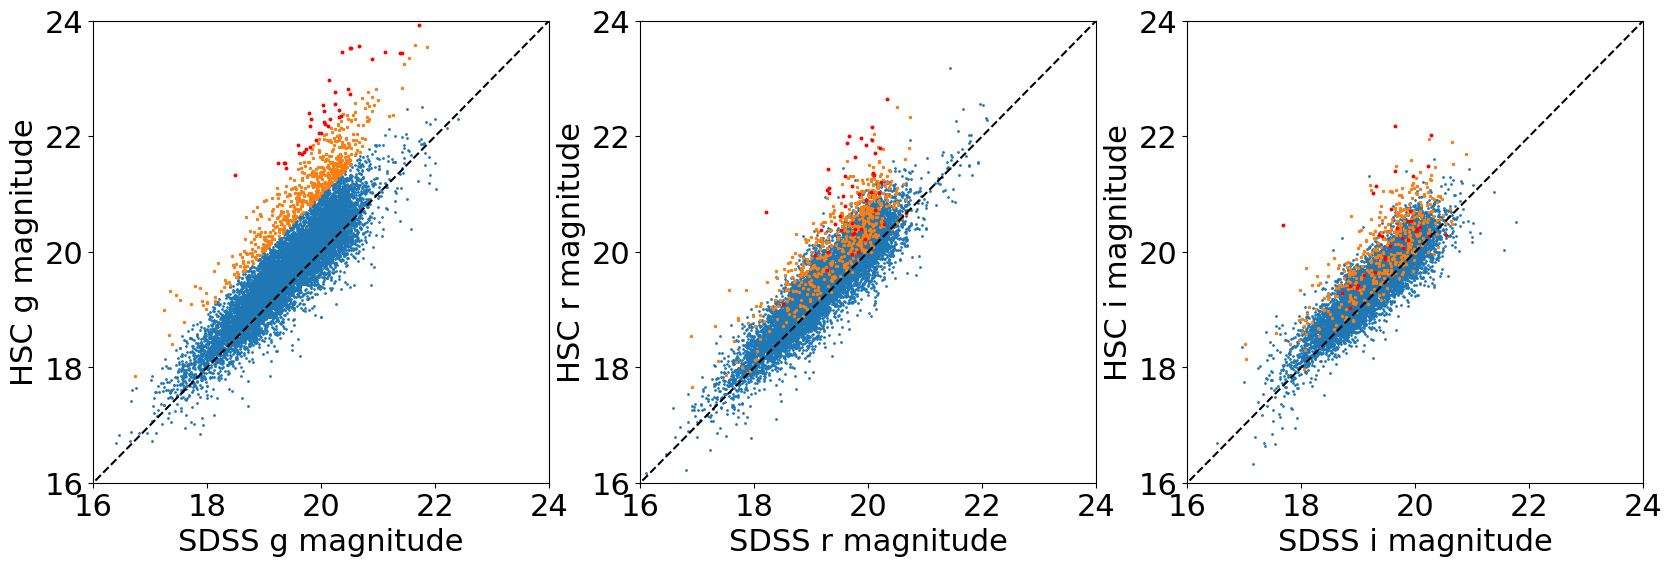

In [175]:
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,2],matched_array_filtered[:,8+2],s=1)
plt.scatter(matched_array_filtered[:,2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,8+2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,8+2][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(16,24)
plt.ylim(16,24)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,8+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(16,24)
plt.ylim(16,24)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,8+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(16,24)
plt.ylim(16,24)

In [192]:
#select orange sample (1 mag difference in g) and red sample (2 mag difference in g)
orange_sample=matched_array_filtered[(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>1]
red_sample=matched_array_filtered[(matched_array_filtered[:,8+2]-matched_array_filtered[:,2])>2]

In [199]:
# make a nice structured array for two samples
orange_sample_data = np.zeros(len(orange_sample), dtype={'names':('ra (SDSS)', 'dec (SDSS)', 'g-band (SDSS)', 'g-band err (SDSS)', 'r-band (SDSS)', 'r-band err (SDSS)','i-band (SDSS)', 'i-band err (SDSS)',
                                                    'ra (HSC)', 'dec (HSC)', 'g-band (HSC)', 'g-band err (HSC)', 'r-band (HSC)', 'r-band err (HSC)','i-band (HSC)', 'i-band err (HSC)'),
                          'formats':('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8')})

for i in range(len(orange_sample_data.dtype.names)):
    orange_sample_data[orange_sample_data.dtype.names[i]] = orange_sample[:,i]


red_sample_data = np.zeros(len(red_sample), dtype={'names':('ra (SDSS)', 'dec (SDSS)', 'g-band (SDSS)', 'g-band err (SDSS)', 'r-band (SDSS)', 'r-band err (SDSS)','i-band (SDSS)', 'i-band err (SDSS)',
                                                    'ra (HSC)', 'dec (HSC)', 'g-band (HSC)', 'g-band err (HSC)', 'r-band (HSC)', 'r-band err (HSC)','i-band (HSC)', 'i-band err (HSC)'),
                          'formats':('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8')})

for i in range(len(red_sample_data.dtype.names)):
    red_sample_data[red_sample_data.dtype.names[i]] = red_sample[:,i]

In [201]:
#export
np.save(DATA_DIRECTORY+'orange_sample_data',orange_sample_data)
np.save(DATA_DIRECTORY+'red_sample_data',red_sample_data)

In [240]:
#export
np.savetxt(DATA_DIRECTORY+'orange_sample_data.txt',orange_sample_data,delimiter=',',comments='# created with code at https://github.com/nevencaplar/Variability/tree/master/HSC \n# sample of DR7 QSO that are at least 1 cmodel mag dimmer in g-band HSC \n', fmt='%8.6f',header='#ra (SDSS), dec (SDSS), g-band (SDSS), g-band err (SDSS), r-band (SDSS), r-band err (SDSS), i-band (SDSS), i-band err (SDSS), ra (HSC), dec (HSC), g-band (HSC), g-band err (HSC), r-band (HSC), r-band err (HSC), i-band (HSC), i-band err (HSC)')
np.savetxt(DATA_DIRECTORY+'red_sample_data.txt',red_sample_data,delimiter=',',comments='# created with code at https://github.com/nevencaplar/Variability/tree/master/HSC  \n# sample of DR7 QSO that are at least 2 cmodel mag dimmer in g-band HSC \n', fmt='%8.6f', header='#ra (SDSS), dec (SDSS), g-band (SDSS), g-band err (SDSS), r-band (SDSS), r-band err (SDSS), i-band (SDSS), i-band err (SDSS), ra (HSC), dec (HSC), g-band (HSC), g-band err (HSC), r-band (HSC), r-band err (HSC), i-band (HSC), i-band err (HSC)')